In [23]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

from tqdm import tqdm_notebook

In [ ]:
# mark rc and agb include in fitting
# run with new salaris -0.08
# maybe a few younger clusters
# with gaia included

In [13]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook

class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,mh,am,distance,rv,isochrones):
        
        '''
        feh: [float] metallicity [M/H] of star
        am: [float] [$\alpha$/M] of star
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.salfeh = mh+np.log10(0.638*(10**am)+0.362) #Salaris et al. 1993
        self.dist = distance
        
        # PARSEC isochrones
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands
        self.leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
            rv: Rv value (=Av/E(B_V))
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/self.rv
        return alav    
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            ak: extinction in the 2MASS K band
            
            # parameters defined in __init__
            self.dist: distance to star
            self.iso: set of PARSEC isochrones
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.cardelli_alav(self.leff['BP'])/self.cardelli_alav(self.leff['K'])
        arpak = self.cardelli_alav(self.leff['RP'])/self.cardelli_alav(self.leff['K'])
        ajak = self.cardelli_alav(self.leff['J'])/self.cardelli_alav(self.leff['K'])
        ahak = self.cardelli_alav(self.leff['H'])/self.cardelli_alav(self.leff['K'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        #print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl = InterpolatedUnivariateSpline(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
            #print('[BP,RP,J,H,K]: ',calc_mags)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            #print('[lgage_lo,lgage_hi]: ',[lgage_lo,lgage_hi])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = InterpolatedUnivariateSpline(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = InterpolatedUnivariateSpline(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            #print('[BP,RP,J,H,K]: ',calc_mags)
            return calc_mags

In [11]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

# PARSEC

In [3]:
### massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]
massive = massive[np.argsort(massive['logAge'])]
massive = Table(massive)['MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# GCs

In [4]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [5]:
gcs.columns

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

In [14]:
from scipy.optimize import curve_fit

# leff2MASS = {'Jmag':12345.,'Hmag':16393.,'Ksmag':21757.}

p0 = [12.0,0.5]

idx = 1024
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,3.1,massive)
# CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx])

popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                      np.array([[gcs['GAIA_PHOT_BP_MEAN_MAG'][idx],gcs['GAIA_PHOT_RP_MEAN_MAG'][idx],
                                 gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]]],dtype=float).T.ravel(),
                      p0=p0,bounds=((0.,0.),(14.,2.)),method='trf')

print('Initial',p0)
print('Age; Ak',popt)
print(pcov)

print(CalcAge.Teff2AppMags(gcs['TEFF'][idx],6.27494611,0.07286526))
print(np.array([gcs['GAIA_PHOT_BP_MEAN_MAG'][idx],gcs['GAIA_PHOT_RP_MEAN_MAG'][idx],gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]]))

Initial [12.0, 0.5]
Age; Ak [5.48375787 0.02332413]
[[ 6.11257961e-03 -1.30079662e-04]
 [-1.30079662e-04  5.38628286e-06]]
[14.8544696  13.40654451 12.29858059 11.65707416 11.52972992]
[14.347263 13.06636  12.136    11.499    11.411   ]


In [15]:
### GCs distances in pc
harris = np.array([4.5,4.4,6.4,4.8,7.1,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,4.0,12.9,12.1,9.6,8.9,4.9,
                   8.6,2.3,4.0,5.2])*1000.

gcs_dist = 999999.0*np.ones(len(gcs))
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs_dist[clus] = harris[i]

# ### Run 2MASS code
# guess_ages = np.arange(0,14)
# guess_aks = [0,0.5,1.0]

# best_ages = 999999.0*np.ones(len(gcs))
# best_chis = 999999.0*np.ones(len(gcs))
# best_aks = 999999.0*np.ones(len(gcs))

# for i in tqdm_notebook(range(len(gcs))):
#     curve_ages = []
#     curve_aks = []
#     curve_chi = []
    
#     CalcAge = WhatsMyAgeAgain(gcs['M_H'][i],gcs['ALPHA_M'][i],gcs_dist[i],massive)
#     for j in range(len(guess_ages)):
#         for k in range(len(guess_aks)):
#             try:
#                 popt,_ = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][i],
#                                    np.array([[gcs['J'][i],gcs['H'][i],gcs['K'][i]]],dtype=float).T.ravel(),
#                                    p0=[guess_ages[j],guess_aks[k]],bounds=((0.,0.),(14.,2.)),method='trf',
#                                    sigma=[gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]],maxfev=5000)
            
#                 curve_ages.append(popt[0])
#                 curve_aks.append(popt[1])
#                 curve_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][i],popt[0],popt[1]))
            
#                 obs_mags = np.array([gcs['J'][i],gcs['H'][i],gcs['K'][i]])
#                 obs_mags_err = np.array([gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]])
            
#                 curve_chi.append(sum((curve_mags-obs_mags)**2/obs_mags_err**2))
            
#             except:
#                 print([i,j,k])
#                 curve_ages.append(999999.0)
#                 curve_aks.append(999999.0)
#                 curve_mags = np.array([999999.0,999999.0,999999.0])
                
#                 obs_mags = np.array([gcs['J'][i],gcs['H'][i],gcs['K'][i]])
#                 obs_mags_err = np.array([gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]])
#                 curve_chi.append(999999.0)
                
#     best_idx = np.asarray(curve_chi).argmin()
#     best_chis[i] = np.min(curve_chi)
#     best_ages[i] = np.asarray(curve_ages)[best_idx]
#     best_aks[i] = np.asarray(curve_aks)[best_idx]

In [16]:
gcs_clus = np.unique(gcs['CLUSTER'])
ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)
# ejk = ejk_ak*best_aks

# for i in range(len(gcs_clus)):
#     clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(gcs['LOGG']<2.984853))
#     isopick = np.where(massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][clus])+
#                                               np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][clus]))+0.362)))
    
#     plt.figure(figsize=[20,20])
#     plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],massive['Ksmag'][isopick]+5.*np.log10(harris[i])-5.0,
#                 c=10**massive['logAge'][isopick]/10**9,cmap='tab20',zorder=0)
#     plt.colorbar()

#     plt.errorbar((gcs['J']-gcs['K']-ejk)[clus],gcs['K'][clus]-best_aks[clus],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[clus],yerr=gcs['K_ERR'][clus],ls='none')
    
#     plt.scatter((gcs['J']-gcs['K']-ejk)[clus],gcs['K'][clus]-best_aks[clus],c='k',marker='*',s=500,zorder=1)
    
#     plt.gca().invert_yaxis()
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
#     plt.title(r'K, J - K; {}; Color as Age'.format(gcs_clus[i]))
#     plt.show()

In [17]:
# plt.plot(best_aks)

In [18]:
m22_idx, = np.where(gcs['CLUSTER']=='M22')
# m22_idx

# plt.plot(best_aks[m22_idx])
# plt.plot(best_aks[m22_idx]*ejk_ak);

# np.median(best_aks[m22_idx])

In [19]:
isopick, = np.where(massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][m22_idx])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][m22_idx]))+0.362))) 
# plt.figure(figsize=[20,20])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# plt.colorbar()

# plt.errorbar((gcs['J']-gcs['K']-ejk)[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[m22_idx],yerr=gcs['K_ERR'][m22_idx],ls='none')
    
# plt.scatter((gcs['J']-gcs['K']-ejk)[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',marker='*',s=500,zorder=1)
    
# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

# #####
# plt.figure(figsize=[20,20])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# plt.colorbar()

# plt.errorbar((gcs['J']-gcs['K']-ejk_ak*np.median(best_aks))[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[m22_idx],yerr=gcs['K_ERR'][m22_idx],ls='none')
    
# plt.scatter((gcs['J']-gcs['K']-ejk_ak*np.median(best_aks))[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#             marker='*',s=500,zorder=1)
    
# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age; Median Ejk'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

# #####
# plt.figure(figsize=[20,20])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# plt.colorbar()

# plt.errorbar((gcs['J']-gcs['K']-ejk_ak*np.mean(best_aks))[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[m22_idx],yerr=gcs['K_ERR'][m22_idx],ls='none')
    
# plt.scatter((gcs['J']-gcs['K']-ejk_ak*np.mean(best_aks))[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#             marker='*',s=500,zorder=1)
    
# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age; Mean Ejk'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

# #####
# plt.figure(figsize=[20,20])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# plt.colorbar()

# plt.errorbar((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[m22_idx],yerr=gcs['K_ERR'][m22_idx],ls='none')
    
# plt.scatter((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c='k',marker='*',s=500,zorder=1)
    
# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

In [ ]:
# for i in range(len(np.unique(gcs[m22_idx]['APOGEE_ID']))):
#     print(r'{}: {}'.format(np.unique(gcs[m22_idx]['APOGEE_ID'])[i],
#                            np.where(gcs['APOGEE_ID']==np.unique(gcs[m22_idx]['APOGEE_ID'])[i])))
    
# for i in m22_idx:
#     print(gcs['CLUSTER'][i])

# Diagnostic plots for M22

In [195]:
# initial_age = np.array([])
# initial_aks = np.array([])
# for i in tqdm_notebook(range(len(guess_ages))):
#     for j in range(len(guess_aks)):
        
#         initial_age = np.append(initial_age,guess_ages[i])
#         initial_aks = np.append(initial_aks,guess_aks[j])
        
# initial_age
# initial_aks

In [ ]:
# theo_mags0 = []
# theo_magsak = []

# for i in tqdm_notebook(range(len(gcs))):
#     CalcAge = WhatsMyAgeAgain(gcs['M_H'][i],gcs['ALPHA_M'][i],gcs_dist[i],massive)
#     theo0 = []
#     theoak = []
#     for j in range(0,14):
#         theo0.append(CalcAge.Teff2AppMags(gcs['TEFF'][i],j,0))
#         theoak.append(CalcAge.Teff2AppMags(gcs['TEFF'][i],j,best_aks[i]))
    
#     theo_mags0.append(theo0)
#     theo_magsak.append(theoak)

In [ ]:
# plt.figure(figsize=[10,10])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# # plt.colorbar()
    
# plt.scatter((gcs['J']-gcs['K']-ejk)[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c=m22_idx,marker='*',s=500,
#             zorder=1)
# plt.colorbar()

# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

# #######
# plt.figure(figsize=[10,10])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# # plt.colorbar()
    
# plt.scatter((gcs['J']-gcs['K']-ejk)[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c=range(len(m22_idx)),marker='*',
#             s=500,zorder=1)
# plt.colorbar()

# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

In [ ]:
# (gcs['J']-gcs['K']-ejk)[m22_idx][78]

In [20]:
# np.where(gcs[m22_idx]['APOGEE_ID']==gcs[m22_idx]['APOGEE_ID'][78])
# gcs['APOGEE_ID'][m22_idx][78]
m22star = np.where(gcs['APOGEE_ID']=='2M18364201-2351316')
m22star

(array([1826]),)

In [ ]:
# np.min((gcs['J']-gcs['K']-ejk)[m22_idx])
# m22star, = np.where((gcs['J']-gcs['K']-ejk)[m22_idx]==np.min((gcs['J']-gcs['K']-ejk)[m22_idx]))
# m22star

# np.where(gcs[m22_idx]['APOGEE_ID']==gcs[m22_idx]['APOGEE_ID'][m22star])

In [ ]:
# np.array([[gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]]],dtype=float).T.ravel()

In [26]:
print(gcs.columns)

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

In [28]:
### bad distance

ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

initial_age = np.array([])
initial_aks = np.array([])

chi = 999999.0*np.ones((len(ages0),len(aks0)))

idx = m22star
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,3.1,massive)
age = 999999.0*np.ones((len(ages0),len(aks0)))
ak = 999999.0*np.ones((len(ages0),len(aks0)))

cmags = 999999.0*np.ones((len(ages0),len(aks0)))

for i in tqdm_notebook(range(len(ages0))):
    for j in range(len(aks0)):
#         try:
        popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                              np.array([[gcs['GAIA_PHOT_BP_MEAN_MAG'][idx][0],
                                         gcs['GAIA_PHOT_RP_MEAN_MAG'][idx][0],gcs['J'][idx][0],gcs['H'][idx][0],
                                         gcs['K'][idx][0]]],
                                       dtype=float).T.ravel(),
                              p0=[ages0[i],aks0[j]],bounds=((0.,0.),(14.,2.)),method='trf')#,
#                               sigma=np.array([[0.,0.,gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],
#                                                gcs['K_ERR'][idx][0]]],dtype=float).T.ravel())
        
        age[i][j] = popt[0]
        ak[i][j] = popt[1]
        
        initial_age = np.append(initial_age,ages0[i])
        initial_aks = np.append(initial_aks,aks0[j])
        
        calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][idx],popt[0],popt[1]))
        print(calc_mags)
        
        mag_errs = np.array([0.,0.,gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]])
        mags = np.array([gcs['GAIA_PHOT_BP_MEAN_MAG'][idx][0],gcs['GAIA_PHOT_RP_MEAN_MAG'][idx][0],
                         gcs['J'][idx][0],gcs['H'][idx][0],gcs['K'][idx][0]])
        
#         print(sum((calc_mags-mags)**2/mag_errs**2))
    
#         import pdb; pdb.set_trace()
        chi[i][j]= sum((calc_mags-mags)**2/mag_errs**2) #sum((calc_mags-mags)**2/mag_errs**2)

print(np.array([gcs['GAIA_PHOT_BP_MEAN_MAG'][idx][0],gcs['GAIA_PHOT_RP_MEAN_MAG'][idx][0],gcs['J'][idx][0],
                gcs['H'][idx][0],gcs['K'][idx][0]]))
print(np.array([0.,0.,gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]]))


#         chi1 = 0.
#         for k in range(len(calc_mags)):
#             chi1+=(calc_mags[k]-mags[k])**2/mag_errs[k]**2
        
    
#         chi[i][j] = chi1
        
#         print(chi1)
#         chi.append(chi1)
            
#         except:
#             print([ages0[i],aks0[j]])
#             age[i][j] = popt[0]
#             ak[i][j] = popt[1]
        
#             initial_age = np.append(initial_age,ages0[i])
#             initial_aks = np.append(initial_aks,aks0[j])
        
#             calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][idx],popt[0],popt[1]))
        
#             mag_errs = np.array([gcs['J_ERR'][idx],gcs['H_ERR'][idx],gcs['K_ERR'][idx]])
#             mags = np.array([gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]])
    
#             chi1 = 0.
#             for k in range(len(calc_mags)):
#                 chi1+=(calc_mags[k]-mags[k])**2/mag_errs[k]**2
        
#         chi[i][j] = 999999.0
    
# bestind = np.asarray(chi).argmin()
# bestchi = np.min(chi)  

# print(bestind)
# print(bestchi)
# bestage = age[bestind] 
# bestak = ak[bestind]
# bestmag = cmags[bestind]

# print('chi',bestchi)
# print('Age',bestage)
# print('Ak',bestak)

[999999. 999999. 999999. 999999. 999999.]
[999999. 999999. 999999. 999999. 999999.]
[999999. 999999. 999999. 999999. 999999.]
[999999. 999999. 999999. 999999. 999999.]
[999999. 999999. 999999. 999999. 999999.]
[999999. 999999. 999999. 999999. 999999.]
[14.31877333 12.86532734 11.73441162 11.10918249 10.97287691]
[14.31876851 12.8653243  11.73441026 11.10918163 10.97287637]
[14.31888711 12.86539926 11.73444362 11.10920276 10.97288976]
[14.31876852 12.8653243  11.73441026 11.10918163 10.97287637]
[14.31876852 12.86532431 11.73441026 11.10918163 10.97287637]
[14.31876852 12.8653243  11.73441026 11.10918163 10.97287637]
[14.06917561 12.91470434 12.06446839 11.51972289 11.43459201]
[14.32532    12.86946512 11.73625279 11.11034875 10.97361628]
[14.31876852 12.8653243  11.73441026 11.10918163 10.97287637]
[14.31876852 12.8653243  11.73441026 11.10918163 10.97287637]
[14.31876862 12.86532437 11.73441029 11.10918165 10.97287638]
[14.35597561 12.88884074 11.74487432 11.11580991 10.97707847]
[14.

In [31]:
chi

inf

In [30]:
ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

initial_age = np.array([])
initial_aks = np.array([])

chi = 999999.0*np.ones((len(ages0),len(aks0)))

idx = m22star
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],gcs_dist[m22star],3.1,massive)
age0 = 5.0
ak0 = 0.

popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                              np.array([[gcs['GAIA_PHOT_BP_MEAN_MAG'][idx][0],
                                         gcs['GAIA_PHOT_RP_MEAN_MAG'][idx][0],gcs['J'][idx][0],gcs['H'][idx][0],
                                         gcs['K'][idx][0]]],
                                       dtype=float).T.ravel(),
                              p0=[age0,ak0],bounds=((0.,0.),(14.,2.)),method='trf')#,
#                               sigma=np.array([[gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]]],
#                                              dtype=float).T.ravel())
        
curve_age = popt[0]
curve_ak = popt[1]
print('   ')
print('--- FINAL VALUES ---')
print('curve_fit Age: ',popt[0])
print('curve_fit Ak: ',popt[1])
      
calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][idx],popt[0],popt[1]))

mag_errs = np.array([0.,0.,gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]])
mags = np.array([gcs['GAIA_PHOT_BP_MEAN_MAG'][idx][0],gcs['GAIA_PHOT_RP_MEAN_MAG'][idx][0],gcs['J'][idx][0],
                 gcs['H'][idx][0],gcs['K'][idx][0]])
    
#         import pdb; pdb.set_trace()
chi = sum((calc_mags-mags)**2/mag_errs**2)

print('chi: ',chi)

print('Catalog Mags: ',np.array([gcs['GAIA_PHOT_BP_MEAN_MAG'][idx][0],gcs['GAIA_PHOT_RP_MEAN_MAG'][idx][0],
                                 gcs['J'][idx][0],gcs['H'][idx][0],gcs['K'][idx][0]]))
print('Catalog Mag Errs: ',np.array([0.,0.,gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]]))

   
--- FINAL VALUES ---
curve_fit Age:  13.72492607498577
curve_fit Ak:  0.33069154223151764
chi:  inf
Catalog Mags:  [14.353725 12.837945 11.688    11.072    10.991   ]
Catalog Mag Errs:  [0.    0.    0.025 0.023 0.023]


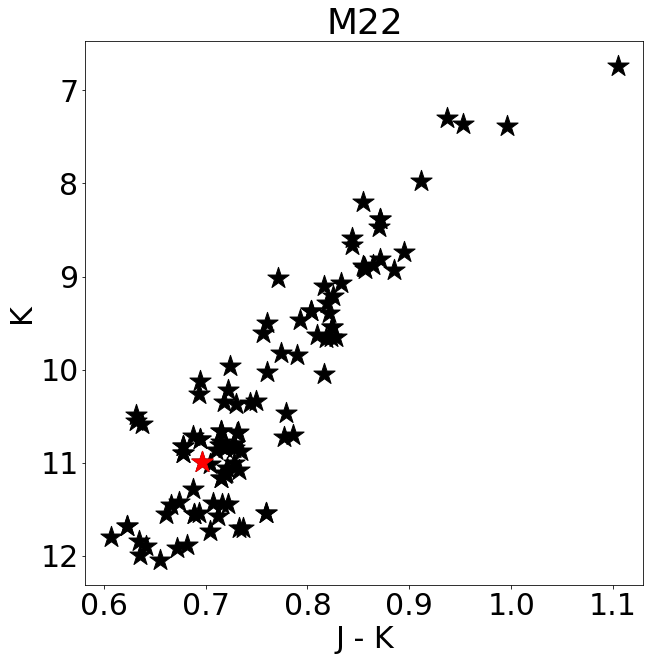

In [272]:
plt.figure(figsize=[10,10])
plt.scatter((gcs['J']-gcs['K'])[m22_idx],(gcs['K'])[m22_idx],c='k',marker='*',s=500,zorder=1) 
plt.scatter((gcs['J']-gcs['K'])[1826],(gcs['K'])[1826],c='r',marker='*',s=500,zorder=1)
plt.gca().invert_yaxis()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'M22')
plt.show()

In [323]:
gcs_dist[m22_idx][0]

3200.0

In [324]:
ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

initial_age = np.array([])
initial_aks = np.array([])

age = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
ak = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
# cmags = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
chi = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))

for k in tqdm_notebook(range(len(m22_idx))):
    
    CalcAge = WhatsMyAgeAgain(gcs['M_H'][m22_idx[k]],gcs['ALPHA_M'][m22_idx[k]],gcs_dist[m22_idx][0],massive)
    
    for i in range(len(ages0)):
        for j in range(len(aks0)):
            try:
                popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][m22_idx[k]],
                              np.array([[gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]]],
                                       dtype=float).T.ravel(),
                              p0=[ages0[i],aks0[j]],bounds=((0.,0.),(14.,2.)),method='trf',
                              sigma=np.array([[gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],
                                               gcs['K_ERR'][m22_idx[k]]]],
                                             dtype=float).T.ravel(),maxfev=5000)
        
                age[i][j][k] = popt[0]
                ak[i][j][k] = popt[1]
        
                calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][m22_idx[k]],popt[0],popt[1]))
                mag_errs = np.array([gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],gcs['K_ERR'][m22_idx[k]]])
                mags = np.array([gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]])
    
#         import pdb; pdb.set_trace()
                chi[i][j][k] = sum((calc_mags-mags)**2/mag_errs**2) #sum((calc_mags-mags)**2/mag_errs**2)
            
            except:
                print([i,j,k])
                age[i][j][k] = 999999.0
                ak[i][j][k] = 999999.0
                chi[i][j][k] = 999999.0 

In [325]:
for i in range(len(m22_idx)):
    print(m22_idx[i])

1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855


In [326]:
np.shape(ak)==np.shape(chi)

True

In [333]:
bestchi = [] #999999.0*np.ones(len(m22_idx))
bestak = [] #999999.0*np.ones(len(m22_idx))

for i in tqdm_notebook(range(len(m22_idx))):
    bestind = np.where(chi[:,:,i]==np.min(chi[:,:,i]))
#     print(chi[:,:,i][bestind])
    bestchi.append(chi[:,:,i][bestind][0])
    bestak.append(ak[:,:,i][bestind][0])
#     bestind = list(zip(*bestind))[0]
#     bestchi = np.append(bestchi,chi[:,:,i][bestind])
#     bestak = np.append(bestak,ak[:,:,i][bestind])

In [350]:
ejk_ak

1.4901972382364816

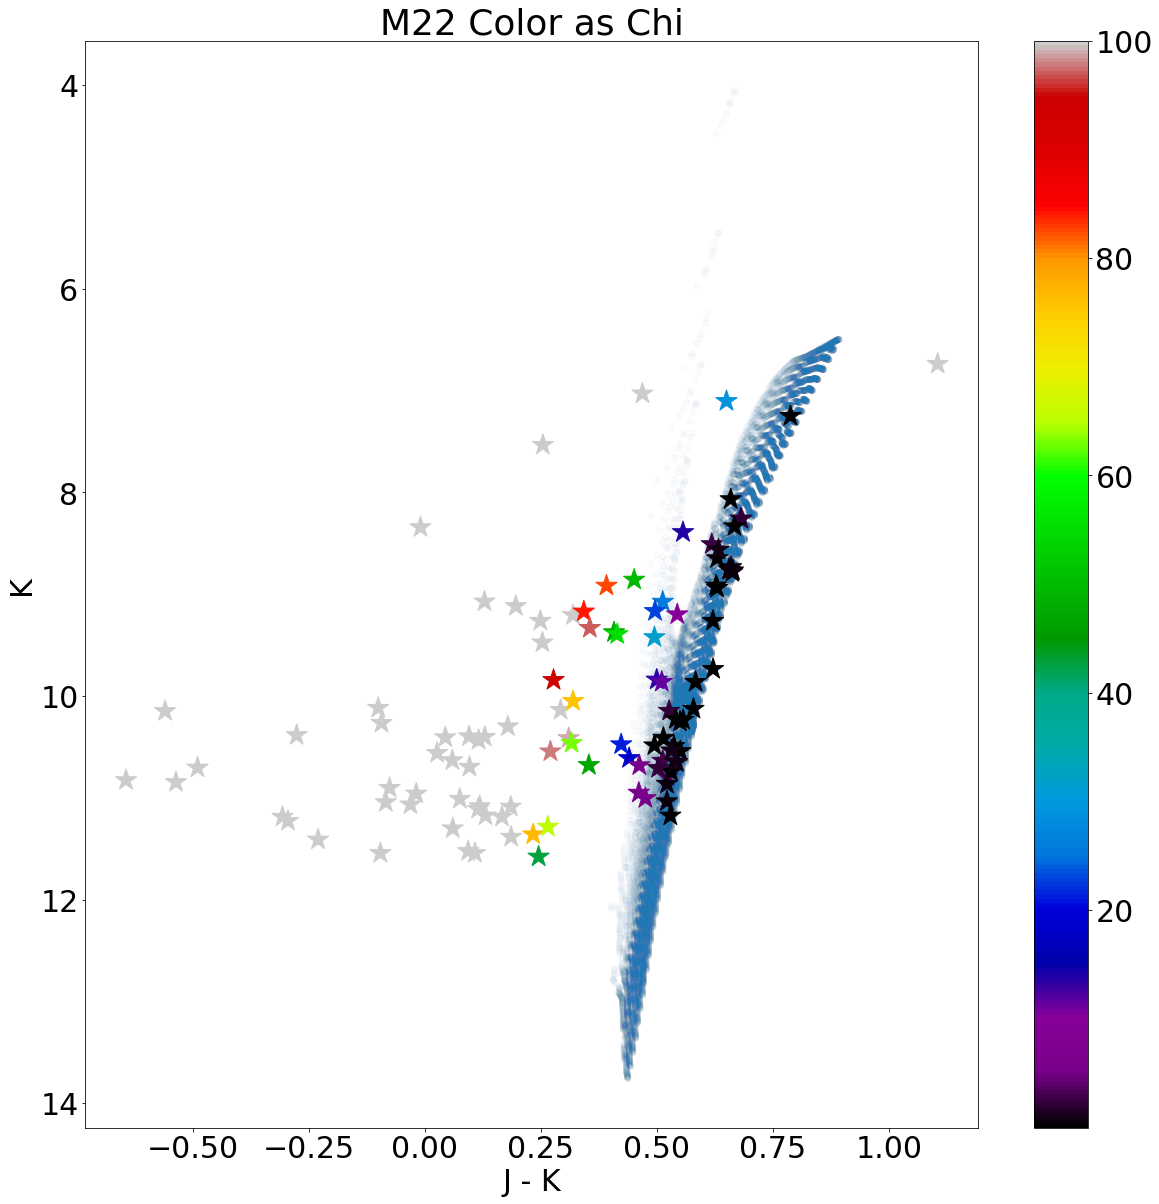

In [367]:
m22iso = np.where(massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][m22_idx])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][m22_idx]))+0.362)))

plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive[m22iso]['Ksmag']+5*np.log10(gcs_dist[m22_idx][0])-5,alpha=0.01)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestak),(gcs['K'])[m22_idx]-bestak,c=bestchi,
            marker='*',s=500,zorder=1,cmap='nipy_spectral',vmax=100) 
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'M22 Color as Chi')
plt.show()

In [ ]:
#all stars keep track of chi sq cmd uses fit ak and color code by chi sq

In [370]:
m22_idx

array([1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758,
       1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769,
       1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780,
       1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791,
       1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802,
       1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813,
       1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824,
       1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835,
       1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846,
       1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855])

In [441]:
ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

curve_chis = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
curve_ages = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
curve_aks = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
for k in tqdm_notebook(range(len(m22_idx))):
        CalcAge = WhatsMyAgeAgain(gcs['M_H'][m22_idx[k]],gcs['ALPHA_M'][m22_idx[k]],gcs_dist[m22_idx[k]],
                                  massive)
        for i in range(len(ages0)):
            for j in range(len(aks0)):
                try:
                    popt,_ = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][m22_idx[k]],
                                  np.array([[gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]]],
                                       dtype=float).T.ravel(),
                                  p0=[ages0[i],aks0[j]],bounds=((12.,0.),(12.01,2.)),method='trf',
                                  sigma=np.array([[gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],
                                                   gcs['K_ERR'][m22_idx[k]]]],dtype=float).T.ravel(),maxfev=5000)
        
                    curve_ages[i,j,k] = popt[0]
                    curve_aks[i,j,k] = popt[1]
      
                    calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][m22_idx[k]],popt[0],popt[1]))
                    mag_errs = np.array([gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],
                                         gcs['K_ERR'][m22_idx[k]]])
                    mags = np.array([gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]])
                    curve_chis[i,j,k] = sum((calc_mags-mags)**2/mag_errs**2)
                    
                except:
                    curve_ages[i,j,k]=999999.0
                    curve_aks[i,j,k]=999999.0
                    curve_chis[i,j,k]=999999.0

In [442]:
bestaks = 999999.0*np.ones(len(m22_idx))
bestchis = 999999.0*np.ones(len(m22_idx))
bestages = 999999.0*np.ones(len(m22_idx))
for i in range(len(m22_idx)):
    bestidx = np.where(curve_chis[:,:,i]==np.min(curve_chis[:,:,i]))
    bestchis[i] = np.median(curve_chis[:,:,i][bestidx])
    bestaks[i] = np.median(curve_aks[:,:,i][bestidx])
    bestages[i] = np.median(curve_ages[:,:,i][bestidx])

0.29133331367512194


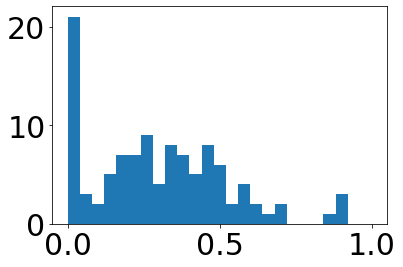

In [447]:
plt.hist(bestaks,range=(0,1.),bins=25)
print(np.median(bestaks))

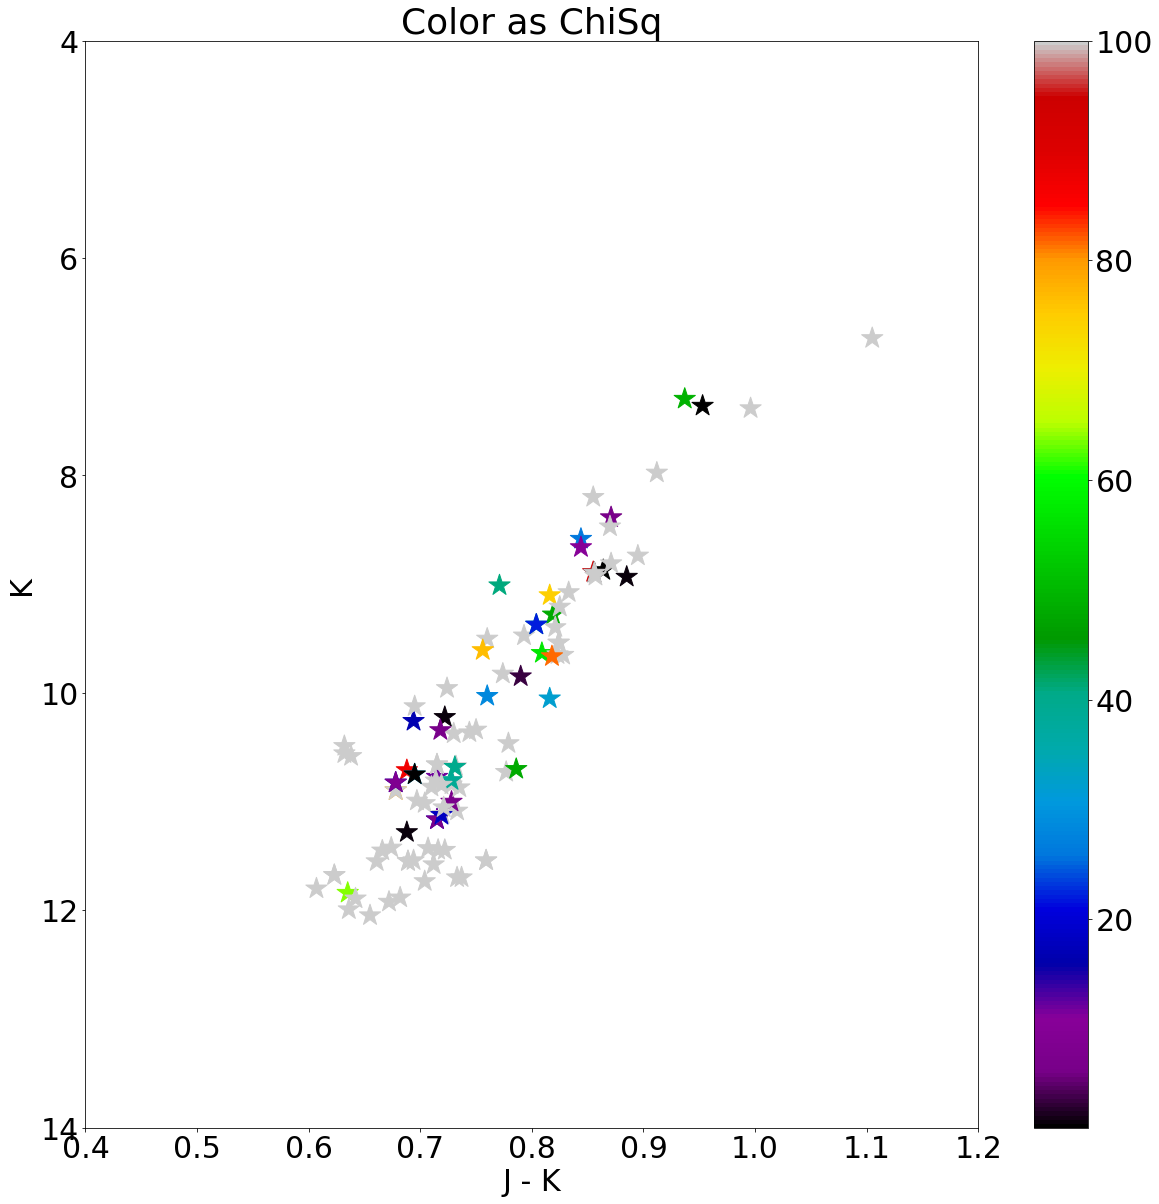

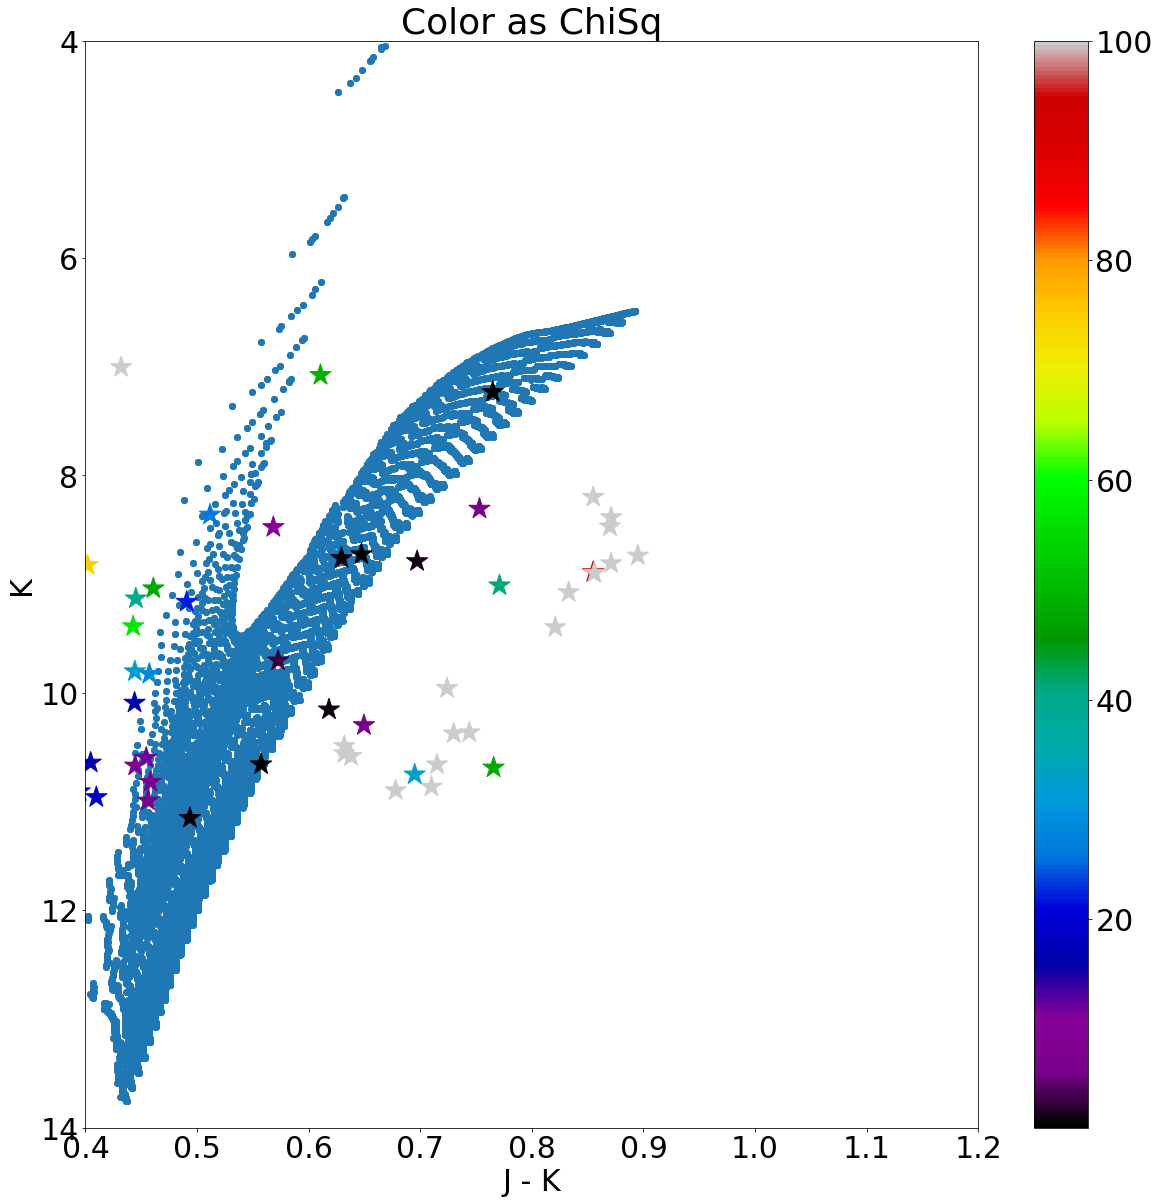

In [452]:
### Without Isochrones
plt.figure(figsize=[20,20])
plt.scatter((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c=bestchis,cmap='nipy_spectral',vmax=100,marker='*',
            s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as ChiSq')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(0.4,1.2)
plt.show()

### With Isochrones
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,c=bestchis,cmap='nipy_spectral',vmax=100,
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as ChiSq')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(0.4,1.2)
plt.show()

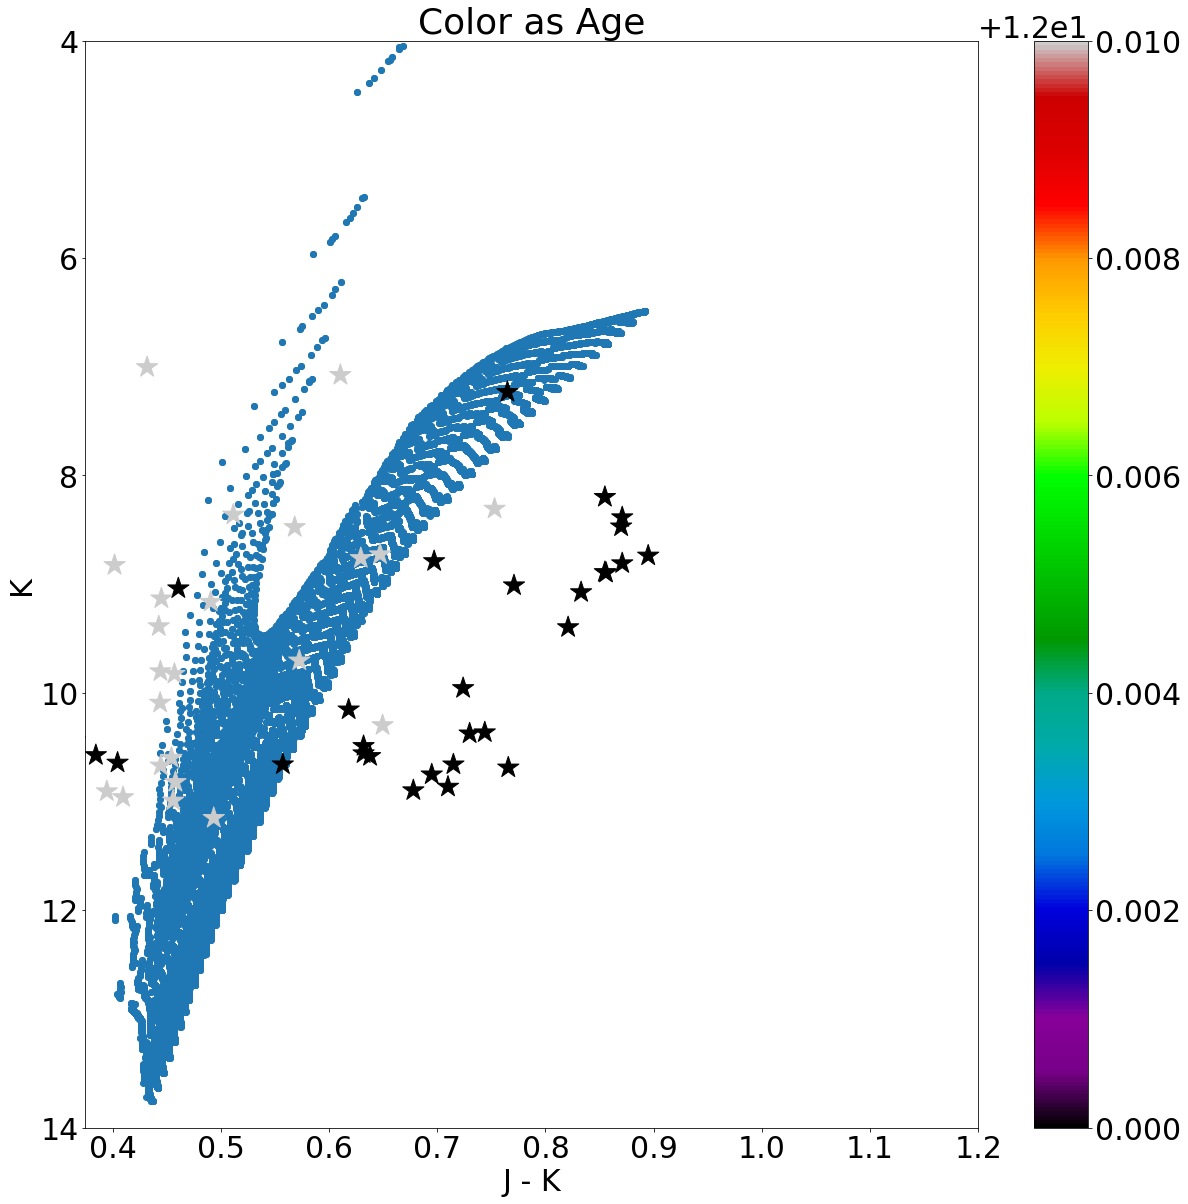

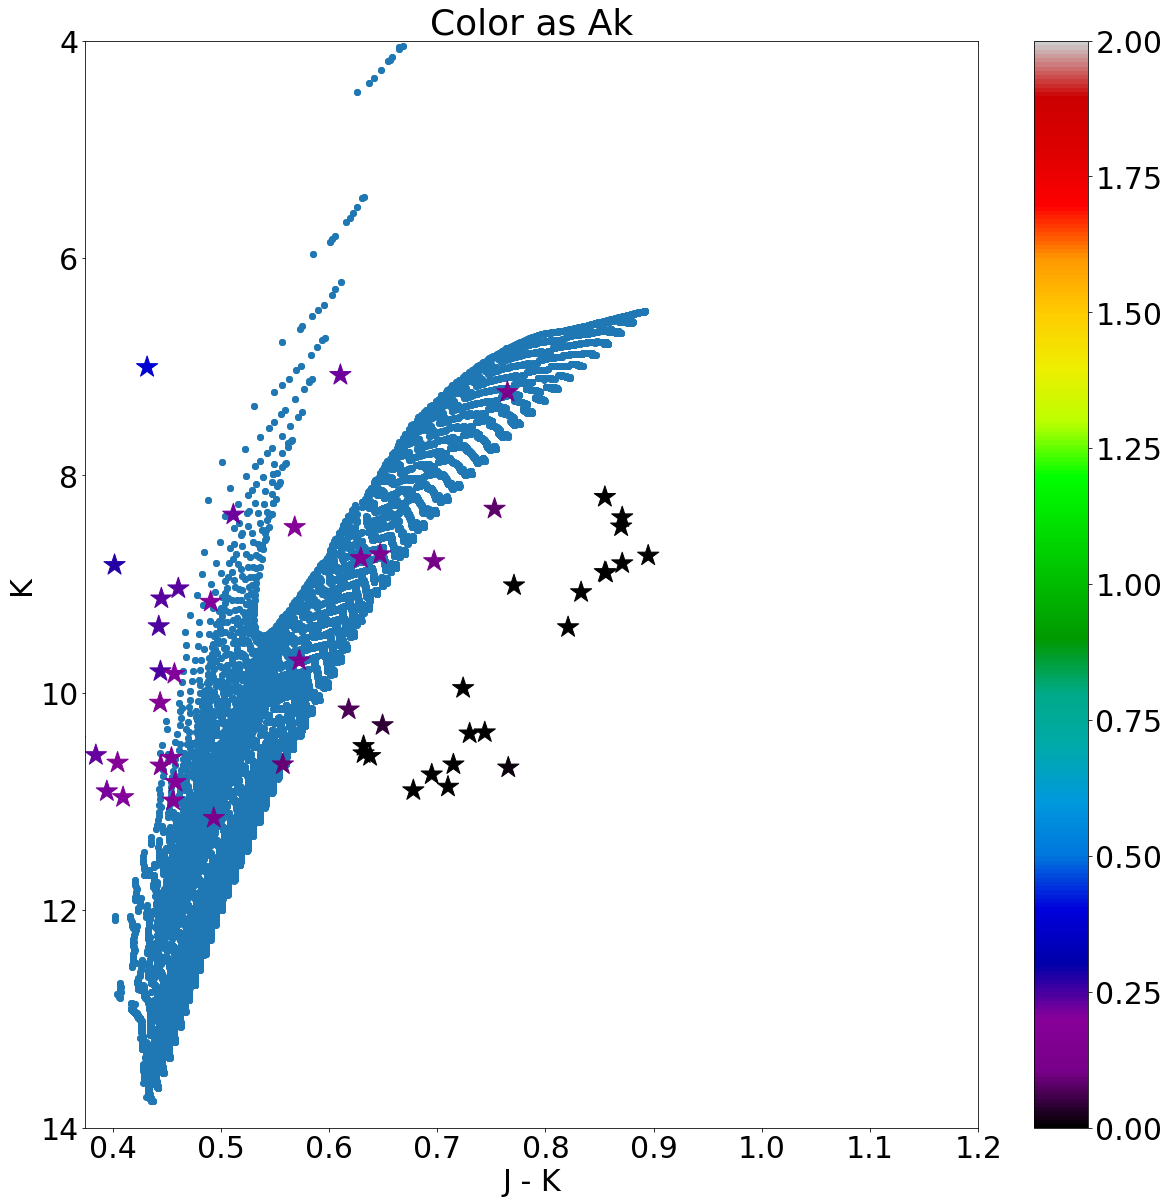

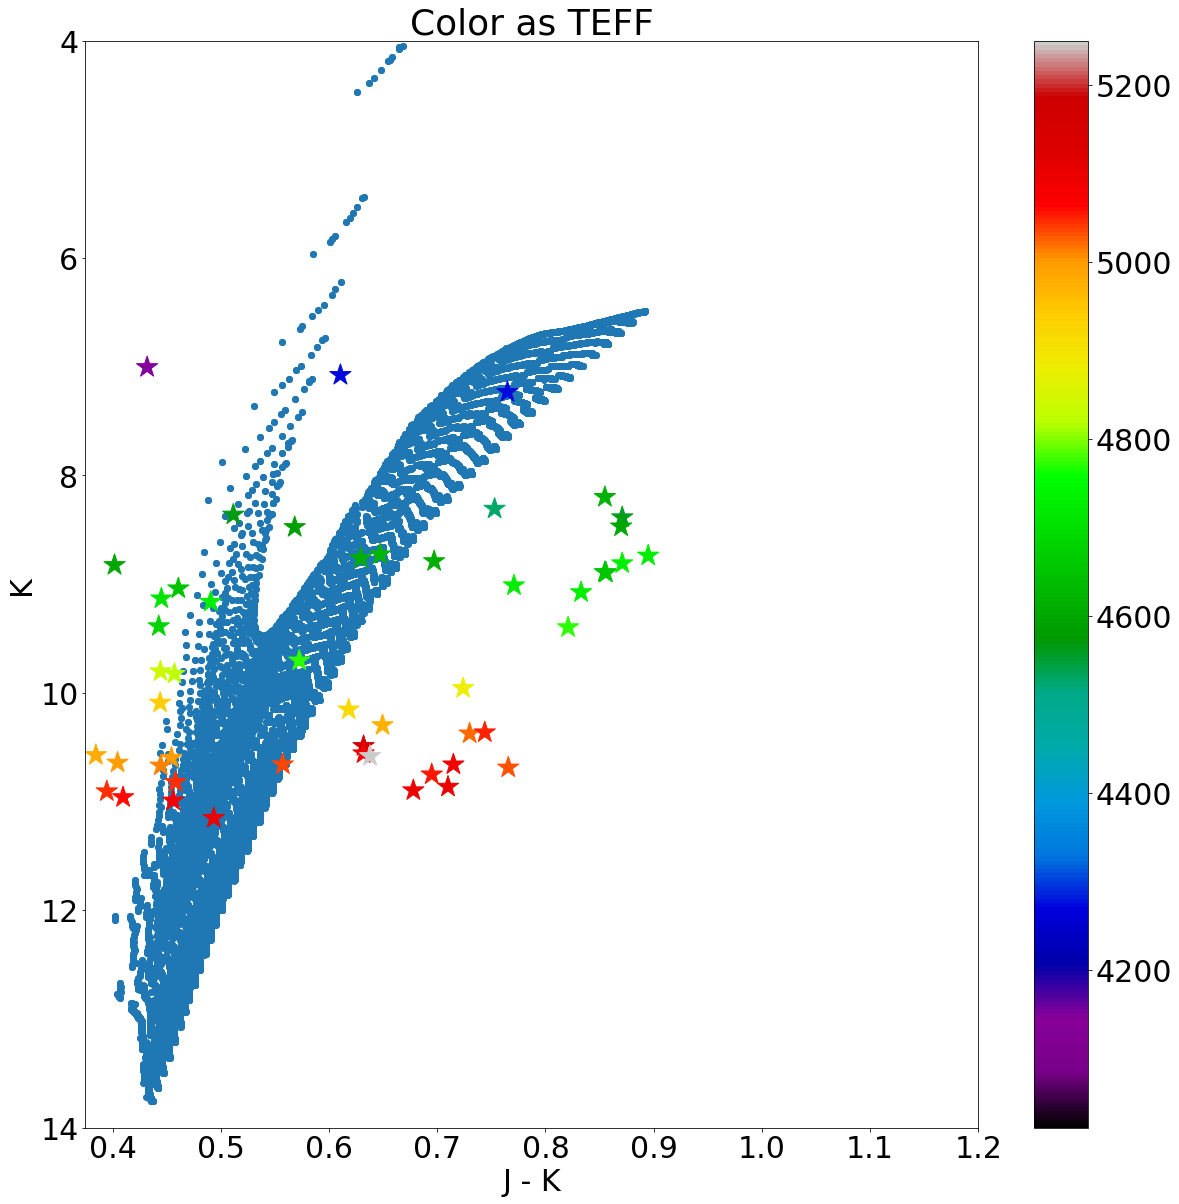

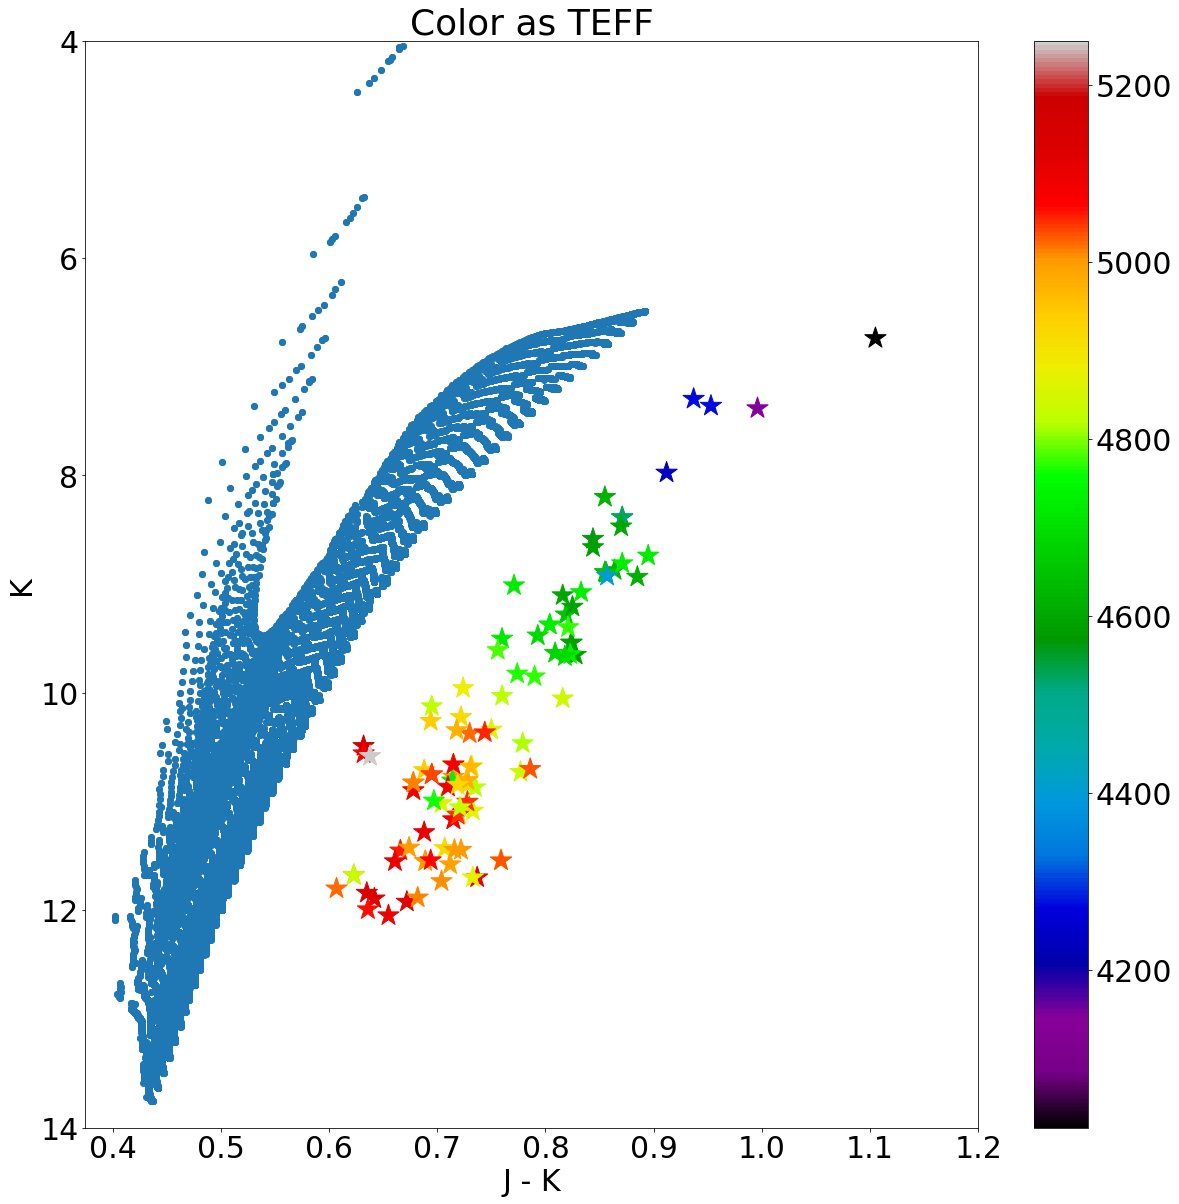

In [455]:
### Age
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,c=bestages,
            cmap='nipy_spectral',vmax=12.01,
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(0.375,1.2)
plt.show()

### Aks
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,c=bestaks,
            cmap='nipy_spectral',
            marker='*',s=500,vmax=2.0)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as Ak')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(0.375,1.2)
plt.show()

### TEFF
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,c=gcs['TEFF'][m22_idx],
            cmap='nipy_spectral',
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as TEFF')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(0.375,1.2)
plt.show()

plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c=gcs['TEFF'][m22_idx],
            cmap='nipy_spectral',
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as TEFF')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(0.375,1.2)
plt.show()

In [456]:
print(gcs['AK_TARG'][m22_idx])

 AK_TARG  
----------
0.16064948
0.15514188
0.15514188
0.15147014
0.11934028
0.11934028
0.18176326
0.13586396
0.20746802
0.16156785
       ...
0.11475018
0.20104204
0.19094434
0.16156785
0.13219222
0.17533816
0.17533816
0.10465159
 0.2469422
0.13494647
 0.2423521
Length = 108 rows


0.16110867


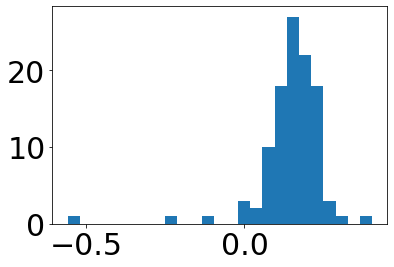

In [459]:
plt.hist(gcs[m22_idx]['AK_TARG'],bins=25)
print(np.median(gcs[m22_idx]['AK_TARG']))

In [ ]:
#age-mag diagnostic few stars
# try redo fititng with rv 3.6
# include gaia bands

In [428]:
gcs_dist[m22_idx]

array([3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.])

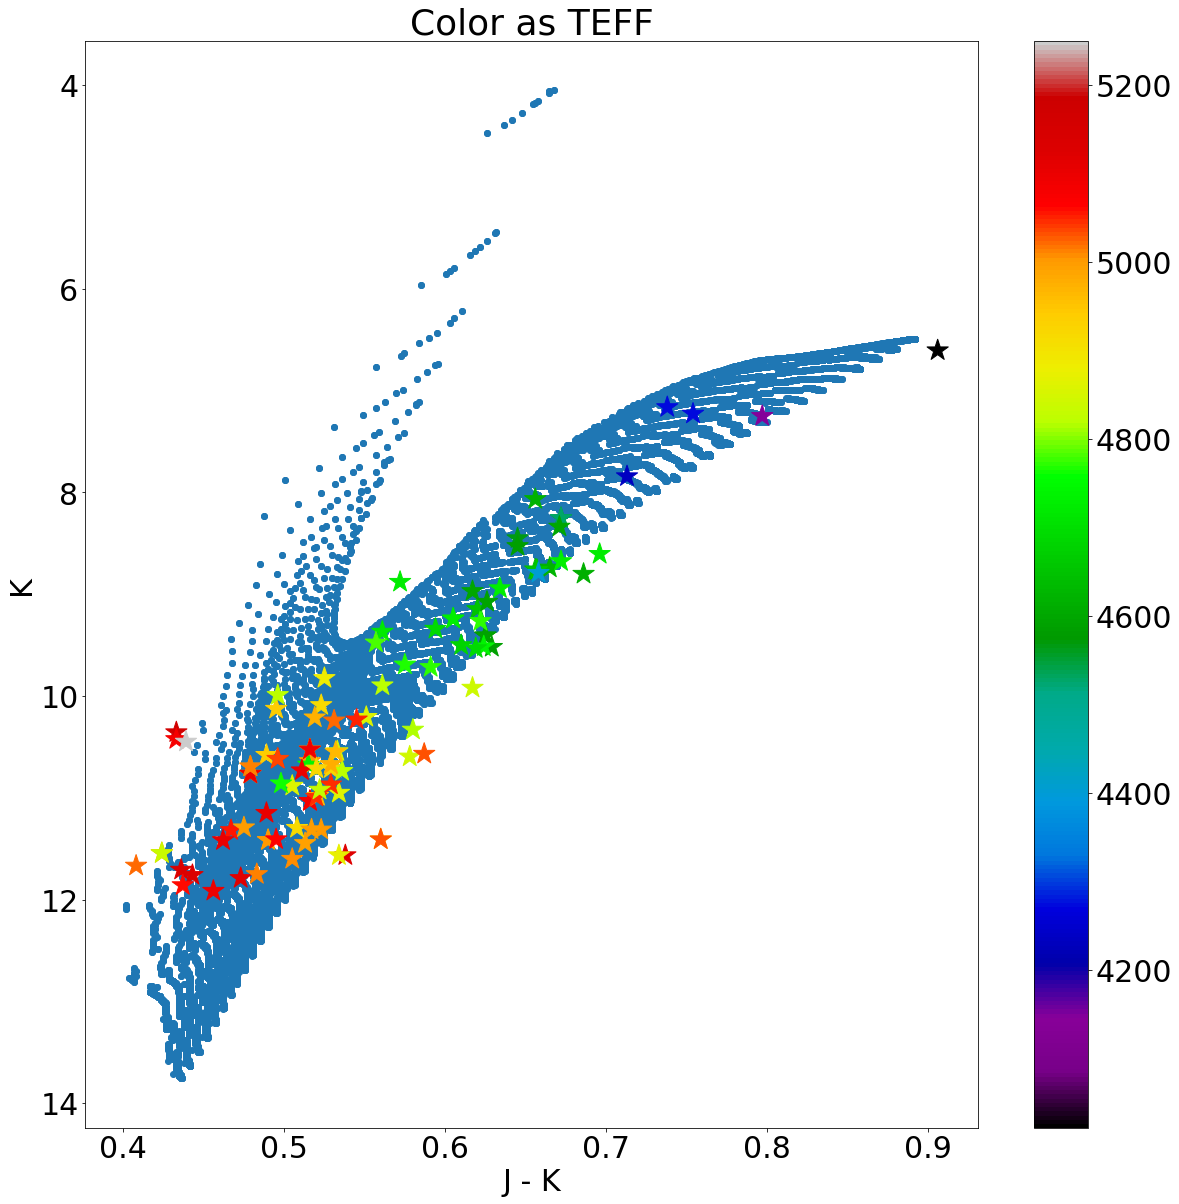

In [440]:
#E(J-K) = .28
#ak = .18

ak_test = 0.1325
ejk_test = 1.5*ak_test

plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_test,gcs['K'][m22_idx]-ak_test,c=gcs['TEFF'][m22_idx],
            cmap='nipy_spectral',
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as TEFF')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.show()

(array([ 3.,  3.,  6.,  6.,  3.,  2.,  1.,  2.,  2., 80.]),
 array([ 1.03494736,  2.33145263,  3.62795789,  4.92446315,  6.22096842,
         7.51747368,  8.81397894, 10.11048421, 11.40698947, 12.70349474,
        14.        ]),
 <a list of 10 Patch objects>)

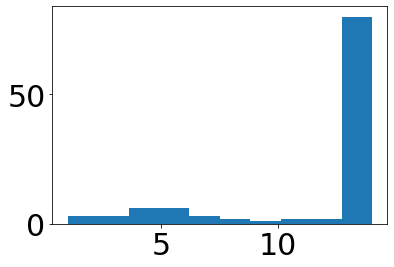

In [425]:
plt.hist(bestages)

0.3806570847132866


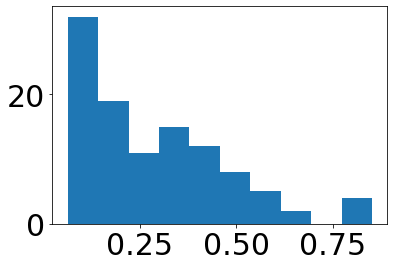

In [417]:
plt.hist(bestaks)
print(np.median(bestaks)*ejk_ak)

In [418]:
#harris E(B-V) = 0.34

(0.34*(cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/
 (cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1)))

0.18928887563095959

In [430]:
ejk_ak

1.4901972382364816

In [429]:
(cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))

0.556731987149881

In [419]:
0.3806570847132866/0.18928887563095959

2.0109849743913175

In [209]:
# idx = m22star
# theo_mags = []
# CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],gcs_dist[idx],massive)
# for i in range(0,14):
#     theo_mags.append(CalcAge.Teff2AppMags(gcs['TEFF'][idx],i,ak[np.where(chi==np.min(chi))]))
    
# # print(theo_mags)

# testmag = CalcAge.Teff2AppMags(gcs['TEFF'][idx],1.59001318,0.051967578556212986)
# print(testmag)
# print(gcs['J'][m22star])
# print(gcs['H'][m22star])
# print(gcs['K'][m22star])

In [213]:
# # run with age
# CalcAge.Teff2AppMags(gcs['TEFF'][idx],1.59001318,0)

In [33]:
aj_ak = cardelli_alav(leff['J'],3.1)/cardelli_alav(leff['K'],3.1)
ah_ak = cardelli_alav(leff['H'],3.1)/cardelli_alav(leff['K'],3.1)

exts = np.array([aj_ak,ah_ak,1.0])*ak[np.where(chi==np.min(chi))]
exts

array([0.1294095 , 0.08197223, 0.05196757])

In [267]:
theo_mags = []
CalcAge = WhatsMyAgeAgain(gcs['M_H'][m22star],gcs['ALPHA_M'][m22star],gcs_dist[m22star],massive)
for i in np.arange(0,15,0.25):
    theo_mags.append(CalcAge.Teff2AppMags(gcs['TEFF'][m22star],i,curve_ak))

Input [Age, Ak]:  [0.0, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [7.397939999999999, 7.69897]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [0.25, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [8.39794, 8.43933]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [0.5, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [8.69897, 8.72016]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [0.75, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [8.875060000000001, 8.8893]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [1.0, 0.8496309455302625]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [1.25, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [9.096910000000001, 9.10551]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [1.5, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [9.17609, 9.18327]
[J,H,K]:  [11.07242535  9.75976336  9.188403  ]
Input [Age, Ak]:  [1.75, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [9.243039999999999, 9.2492]
[J,H,K]:  [11.1596983   9.84611278  9.27478351]
Input [

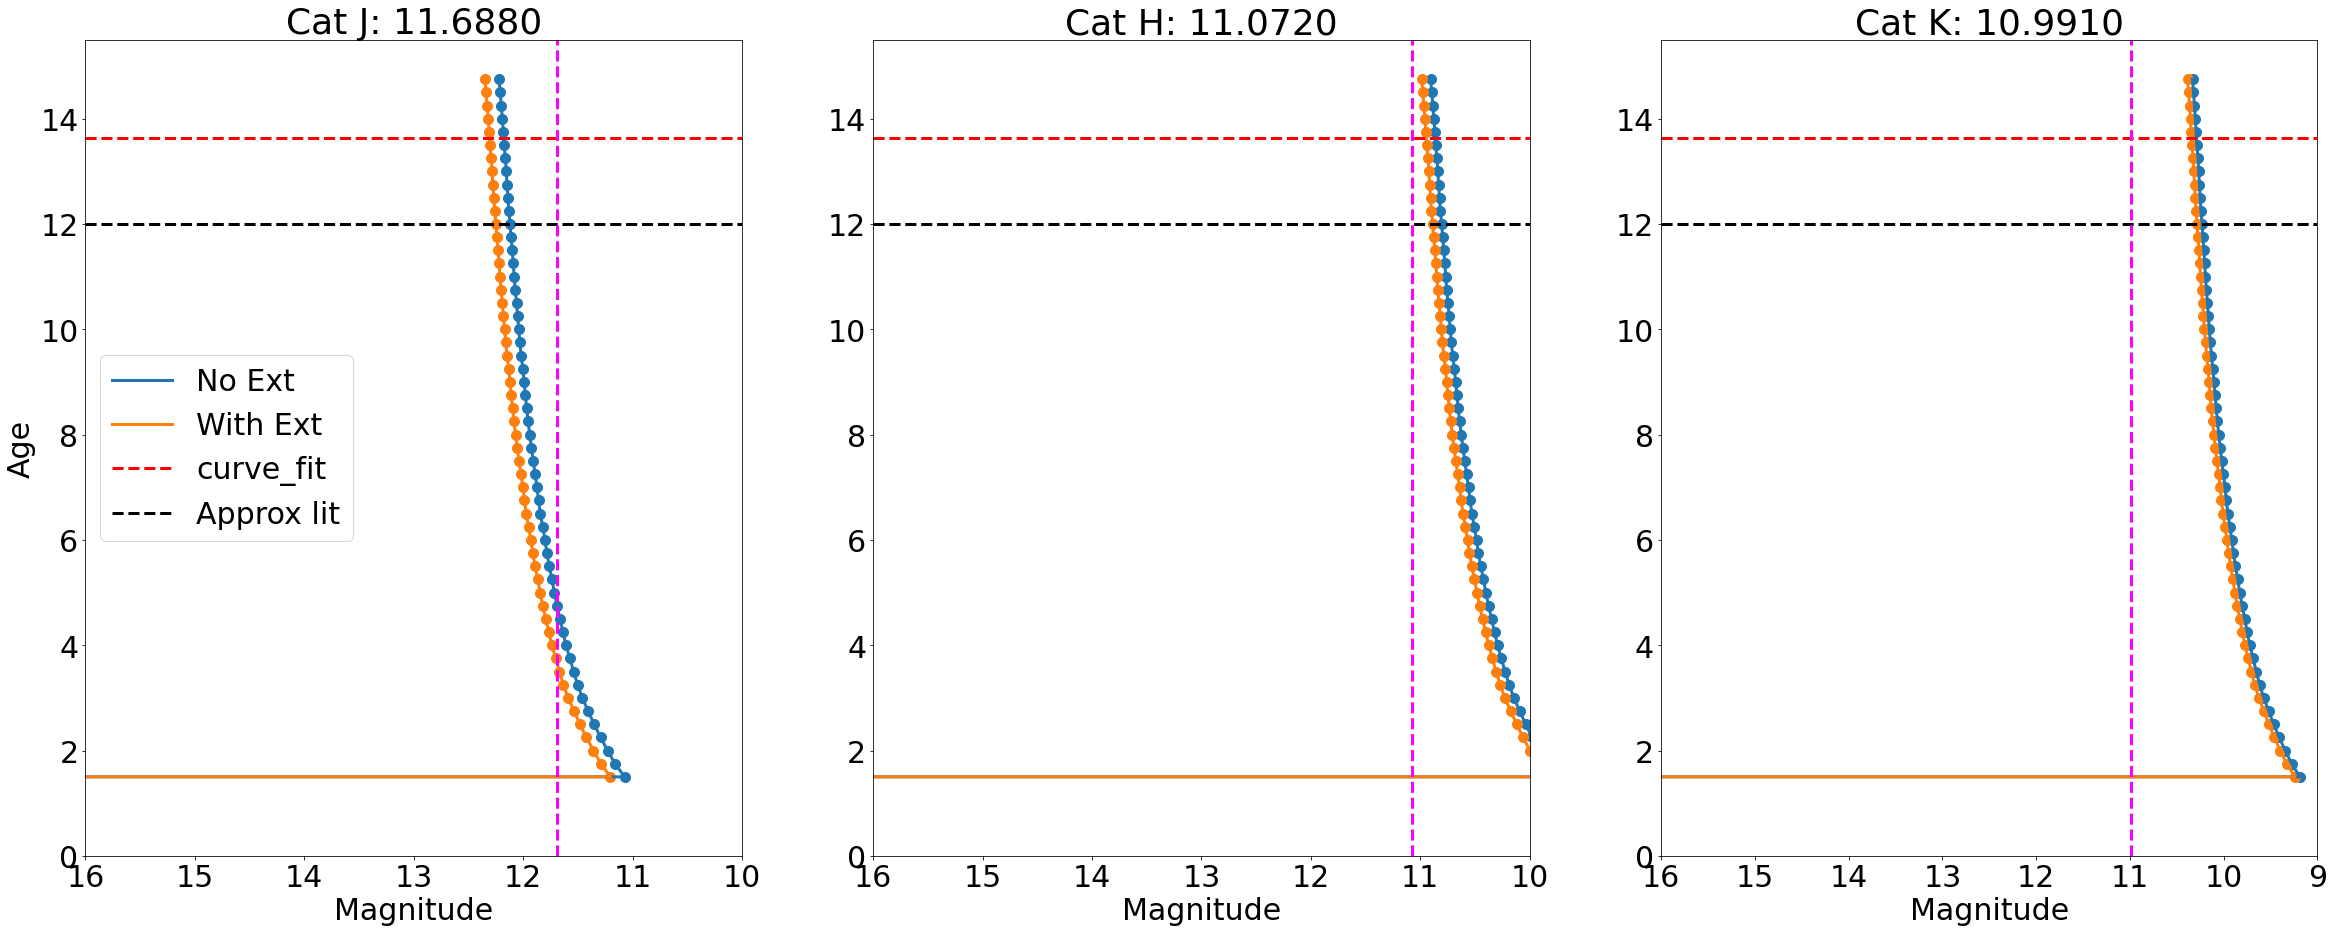

In [270]:
bands = ['J','H','K']
catalog_mags = [gcs[m22star]['J'][0],gcs[m22star]['H'][0],gcs[m22star]['K'][0]]
fig, ax = plt.subplots(1,3,figsize=[40,15])
for i in range(3):
    ax[i].scatter(np.asarray(theo_mags)[:,i],np.arange(0,15,0.25),s=100)
    ax[i].plot(np.asarray(theo_mags)[:,i],np.arange(0,15.,0.25),lw=3.0,label='No Ext')
    ax[i].scatter(np.asarray(theo_mags)[:,i]+exts[i],np.arange(0,15,0.25),s=100)
    ax[i].plot(np.asarray(theo_mags)[:,i]+exts[i],np.arange(0,15,0.25),lw=3.0,label='With Ext')
    ax[i].set_ylim(bottom=0)
    ax[i].axhline(curve_age,c='r',ls='--',label='curve_fit',lw=3.0)
    ax[i].axhline(12,c='k',ls='--',label='Approx lit',lw=3.0)
    ax[i].set_xlabel('Magnitude')
    ax[i].set_title(r'Cat {}: {:.4f}'.format(bands[i],catalog_mags[i]))

ax[0].axvline(catalog_mags[0],ls='--',c='magenta',lw=3.0)
ax[1].axvline(catalog_mags[1],ls='--',c='magenta',lw=3.0)
ax[2].axvline(catalog_mags[2],ls='--',c='magenta',lw=3.0)

# ax[0].set_xlim(12.5,10.)
# ax[1].set_xlim(12,9.0)
# ax[2].set_xlim(12,8.25)

ax[0].set_xlim(16,10)
ax[1].set_xlim(16,10)
ax[2].set_xlim(16,9)

ax[0].legend()

ax[0].set_ylabel('Age')
plt.show()

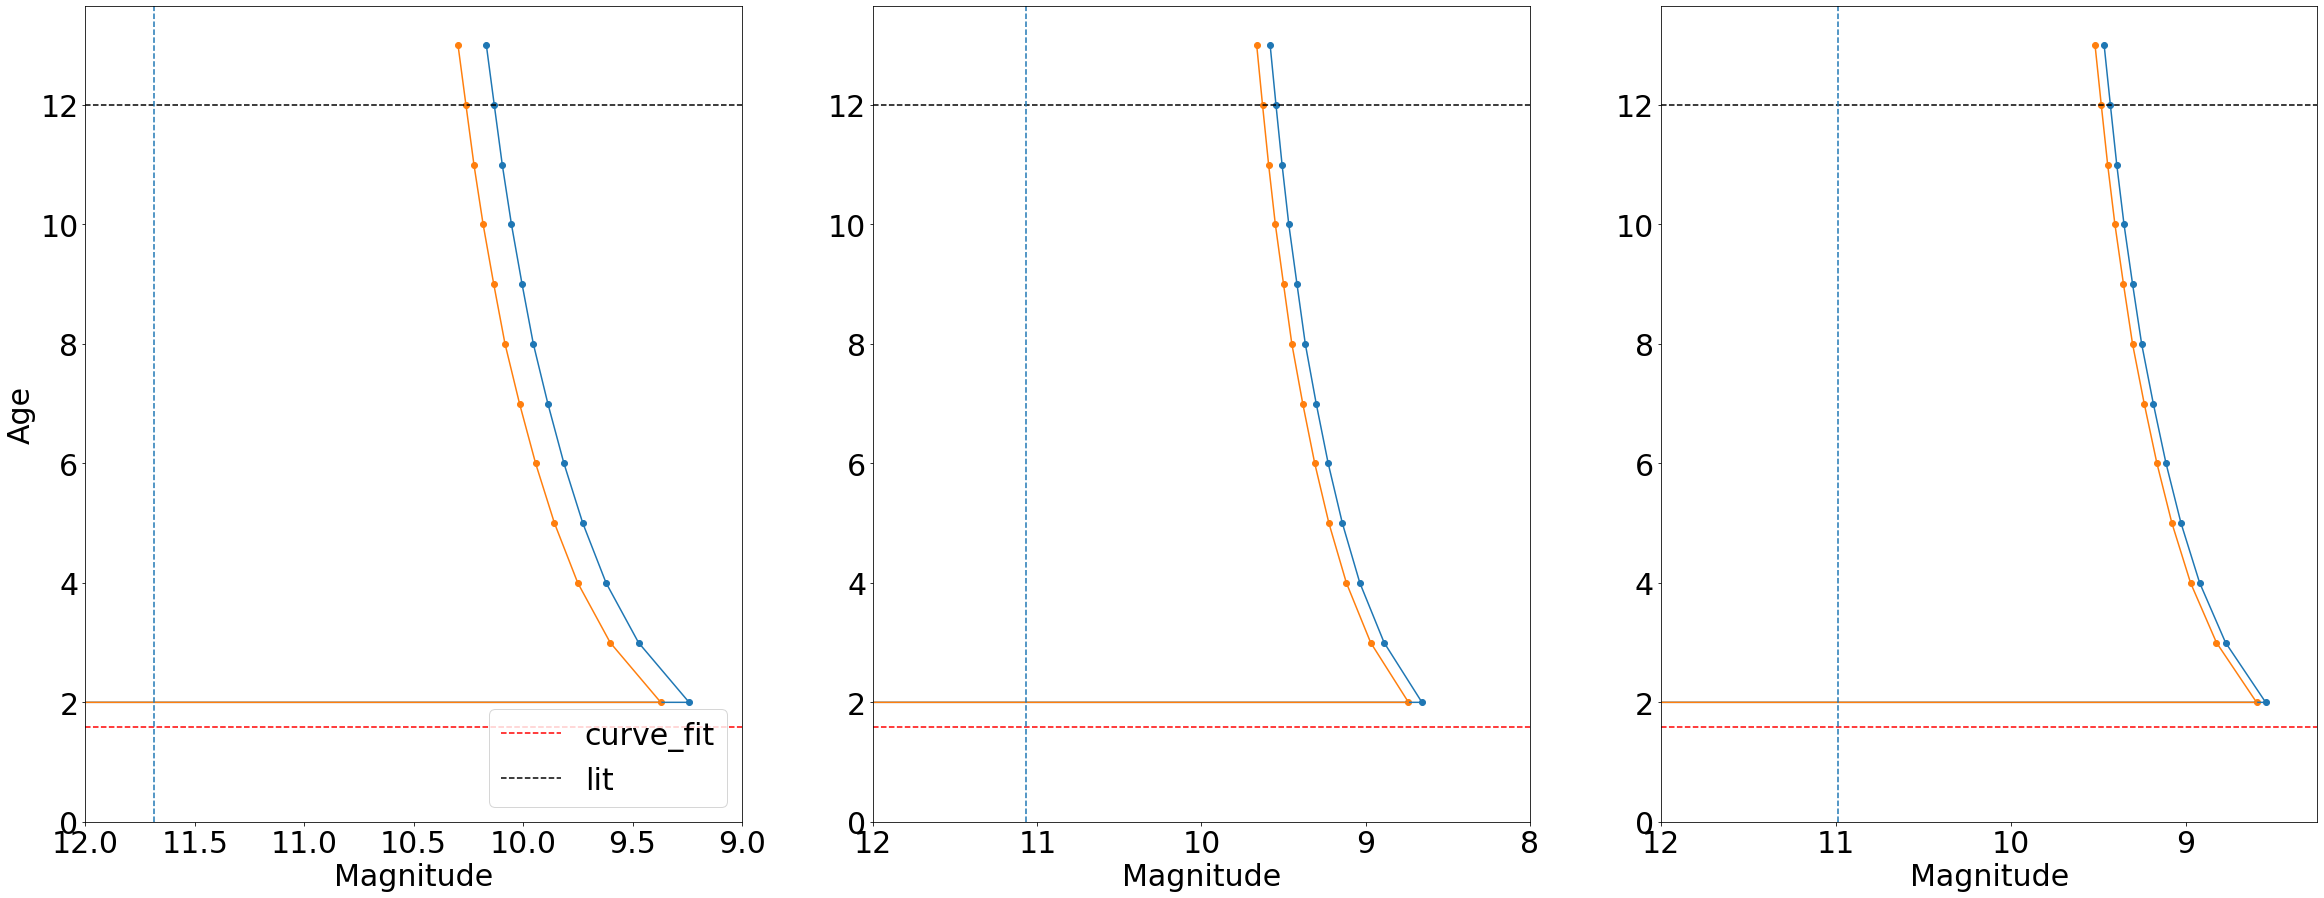

In [83]:
fig, ax = plt.subplots(1,3,figsize=[40,15])
for i in range(3):
    ax[i].scatter(np.asarray(theo_mags)[:,i],range(0,14))
    ax[i].plot(np.asarray(theo_mags)[:,i],range(0,14))
    ax[i].scatter(np.asarray(theo_mags)[:,i]+exts[i],range(0,14))
    ax[i].plot(np.asarray(theo_mags)[:,i]+exts[i],range(0,14))
    ax[i].set_ylim(bottom=0)
    ax[i].axhline(age[np.where(chi==np.min(chi))],c='r',ls='--',label='curve_fit')
    ax[i].axhline(12,c='k',ls='--',label='lit')
    ax[i].set_xlabel('Magnitude')

ax[0].axvline(gcs[idx]['J'][0],ls='--',c='tab:blue')
ax[1].axvline(gcs[idx]['H'][0],ls='--',c='tab:blue')
ax[2].axvline(gcs[idx]['K'][0],ls='--',c='tab:blue')

ax[0].set_xlim(12,9.0)
ax[1].set_xlim(12,8.0)
ax[2].set_xlim(12,8.25)

ax[0].legend()

ax[0].set_ylabel('Age')
plt.show()

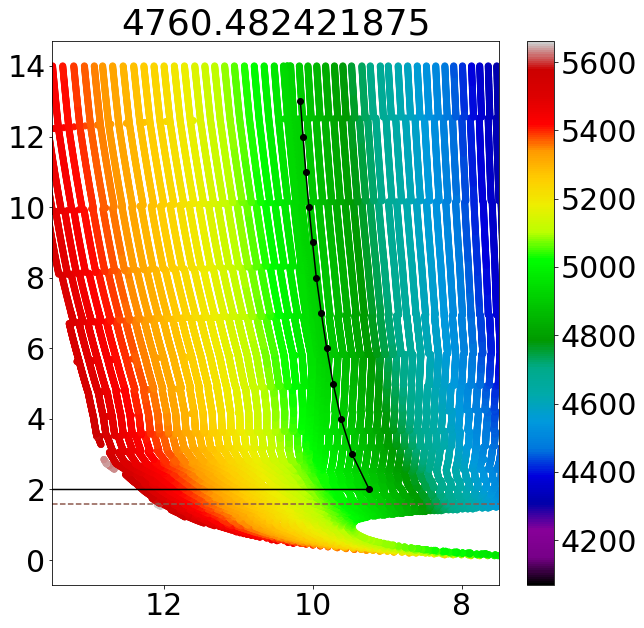

In [109]:
plt.figure(figsize=[10,10])
plt.scatter(massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22star])-5.0,10**massive['logAge'][isopick]/10**9,
            c=10**massive['logTe'][isopick],cmap="nipy_spectral")
plt.colorbar()
plt.plot(np.asarray(theo_mags)[:,0],range(0,14),'o-',c='black')
plt.gca().invert_xaxis()
plt.xlim(13.5,7.5)
plt.axhline(age[np.where(chi==np.min(chi))],c='tab:brown',ls='--',label='curve_fit')
plt.title(r'{}'.format(gcs[idx]['TEFF'][0]));

In [128]:
curvefitage = age[np.where(chi==np.min(chi))][0]
curvefitiso, = np.where((massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][m22star])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][m22star]))+0.362)))&
                    (massive['logAge']==closest(massive['logAge'],np.log10(curvefitage*10**9))))

twgyr, = np.where((massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][m22star])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][m22star]))+0.362)))&
                    (massive['logAge']==closest(massive['logAge'],np.log10(12*10**9))))

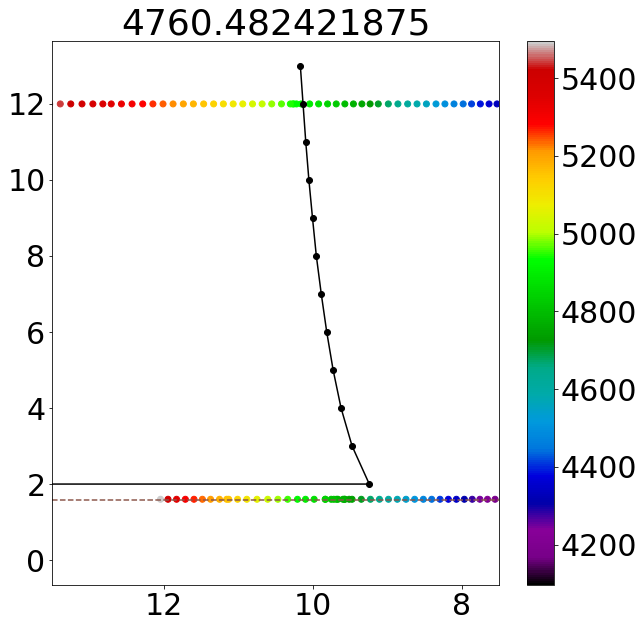

In [129]:
plt.figure(figsize=[10,10])

plt.scatter(massive['Ksmag'][curvefitiso]+5.0*np.log10(gcs_dist[m22star])-5.0,
            10**massive['logAge'][curvefitiso]/10**9,
            c=10**massive['logTe'][curvefitiso],cmap="nipy_spectral")

plt.scatter(massive['Ksmag'][twgyr]+5.0*np.log10(gcs_dist[m22star])-5.0,
            10**massive['logAge'][twgyr]/10**9,
            c=10**massive['logTe'][twgyr],cmap="nipy_spectral")

plt.colorbar()
plt.plot(np.asarray(theo_mags)[:,0],range(0,14),'o-',c='black')
plt.gca().invert_xaxis()
plt.xlim(13.5,7.5)
plt.axhline(age[np.where(chi==np.min(chi))],c='tab:brown',ls='--',label='curve_fit')
plt.title(r'{}'.format(gcs[idx]['TEFF'][0]));

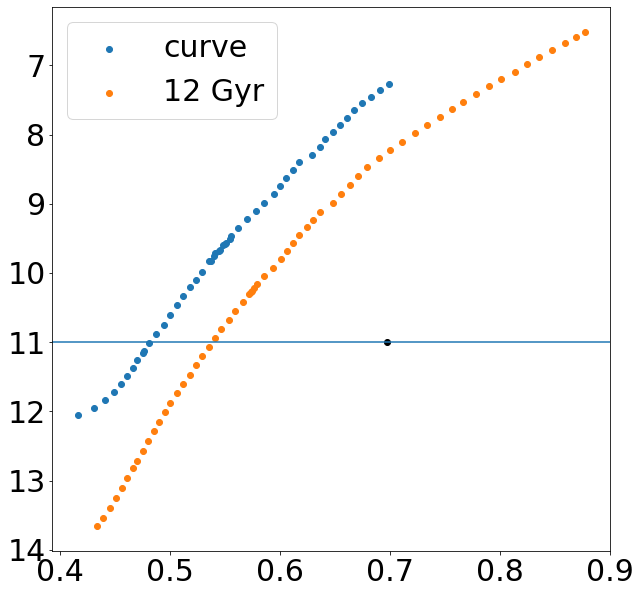

In [162]:
plt.figure(figsize=[10,10])
plt.scatter((massive['Jmag']-massive['Ksmag'])[curvefitiso],
            massive[curvefitiso]['Ksmag']+5.0*np.log10(gcs_dist[m22star])-5.0,label='curve')
plt.scatter((massive['Jmag']-massive['Ksmag'])[twgyr],
            massive[twgyr]['Ksmag']+5.0*np.log10(gcs_dist[m22star])-5.0,label='12 Gyr')
plt.legend()
plt.scatter((gcs['J']-gcs['K'])[m22star],gcs['K'][m22star],c='k')
plt.axhline(gcs['K'][m22star])
plt.gca().invert_yaxis()

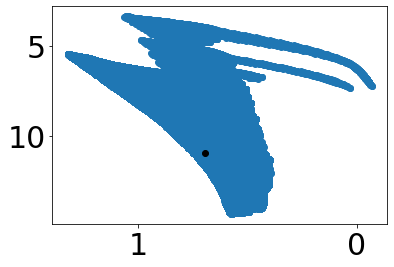

In [133]:
plt.scatter(massive['Jmag']-massive['Ksmag'],massive['Ksmag']+5.0*np.log10(gcs_dist[m22star])-5.0,label='curve')
plt.scatter((gcs['J']-gcs['K'])[m22star],gcs['K'][m22star],c='k')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()